
### Environment setup



In [1]:
begin
	import Pkg
	Pkg.activate(".")
	using OrdinaryDiffEq, Optimization, OptimizationPolyalgorithms, SciMLSensitivity, ModelingToolkit, Optim, ForwardDiff, Plots, DelimitedFiles
end

  Activating project at `~/Documents/Master/MasterThesis/RhoAModelling/Notebooks`



## Data fitting of RhoA activation/deactivation dynamics at the membrane
This notebook contains the code used to fit an ODE model to the experimental data of RhoA activity obtained after local light stimulation at focal adhesions as described in the paper by Heydasch et al. \


Max Heydasch, Lucien Hinderling, Jakobus van Unen, Maciej Dobrzynski, Olivier Pertz
(2023) \
**GTPase activating protein DLC1 spatio-temporally regulates Rho signaling** \
eLife 12:RP90305 \
https://doi.org/10.7554/eLife.90305.1  

Data source: Lucien Hinderling, PertzLab




### Initial steps
##### - Light signal function
To use the gradient for parameter optimisation the ODE system needs to be composed of continuous and differentiable function to avoid instability with the ODE solver. Instead of a step function, the light signal is modelled using a hyperbolic tangent.



In [3]:
# Define symbolic functions and variables for ODE model
begin
	@independent_variables t
	D = Differential(t)
	
	# Light signal function (step function)
	f(t) = (160 <= t <= 160.8)
	@register_symbolic f(t) 
	
    # Use hyperbolic tangent to have continuous derivatives for data fitting as light signal function
	f_tanh(t) = (tanh(100*(t-160))/2 - tanh(100*(t-160.8))/2) 
	@register_symbolic f_tanh(t)
end

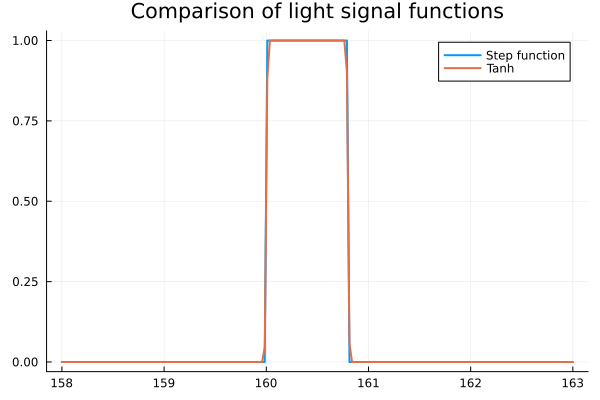

In [4]:
# Check the light signal functions 
begin
	x = LinRange(158, 163, 200)
	y1 = f.(x)
	y2 = f_tanh.(x)
	plot(x, [y1, y2], labels =["Step function" "Tanh"], lw = 2, title="Comparison of light signal functions")
end


##### - Import RhoA data



In [5]:
# Import data saved in txt files (Python preprocessing pickle file)
begin
	path_to_data = "./Data/"
	median_rhoa_NONFA = readdlm(Base.Filesystem.joinpath(path_to_data, "median_rhoa_NONFA_dynamics.txt"), ' ', Float64, '\n')[:, 2]
	median_rhoa_NONFA_KO = readdlm(Base.Filesystem.joinpath(path_to_data, "median_rhoa_NONFA_KO_dynamics.txt"), ' ', Float64, '\n')[:, 2]
	timeframe = LinRange(10, 400, 40)
end

40-element LinRange{Float64, Int64}:
 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, …, 360.0, 370.0, 380.0, 390.0, 400.0

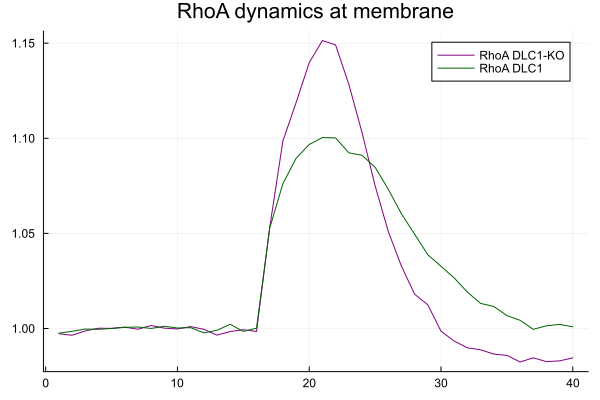

In [6]:
# Visualise data
begin
	plot(median_rhoa_NONFA_KO, label = "RhoA DLC1-KO", fontfamily="Arial", color = "#800080")
	plot!(median_rhoa_NONFA, label = "RhoA DLC1", title= "RhoA dynamics at membrane", color="#006400")
end


### Data fitting



In [7]:
# Custom function to retrieve the index of the parameter in the optimisation solution 
# array using its symbolic expression (symbol) 
function get_idxparam(symbol, prob)
	mtk_p = prob.ps
	mtk_p_array = prob.p.tunable
	for i in eachindex(mtk_p_array)
		if mtk_p[symbol] == mtk_p_array[i]
			return i
		end
	end
end

get_idxparam (generic function with 1 method)


#### 1: membrane and WT cells



In [27]:
# Define RhoA negative autoregulation model for RhoA dynamics in WT
@mtkmodel Rho_dynamics begin
	
	@parameters begin
		Kon_GAP
		Koff_GAP
		Kon_Rho
		Koff_Rho
	end
	
	@variables begin
		GEF(t), [bounds = (0, 10)]
		GAP(t), [bounds = (0, 10)]
		Rho(t), [bounds = (0, 10)]
		S(t)
	end
	
	@equations begin
		# Define linear model with Km = 0
		D(GEF) ~  0.034 * (0.2 * S - GEF)
		D(GAP) ~ Kon_GAP * (1 - GAP) * (Rho - 1) - Koff_GAP * GAP
		D(Rho) ~  Kon_Rho * GEF * (2 - Rho) - Koff_Rho * GAP * Rho
		S ~ f_tanh(t)
	end
end
@mtkbuild Rho_model = Rho_dynamics()

Model Rho_model:
Equations (3):
  3 standard: see equations(Rho_model)
Unknowns (3): see unknowns(Rho_model)
  GEF(t)
  GAP(t)
  Rho(t)
Parameters (4): see parameters(Rho_model)
  Koff_GAP
  Kon_GAP
  Koff_Rho
  Kon_Rho
Observed (1): see observed(Rho_model)

In [10]:
begin
	# Define some initial parameters for the ODE model
	parameter_guess = [0.1, 0.12, 0.13, 0.14]
	
    # Build ODE problems with guess parameters and initial conditions
	Rho_prob = ODEProblem(Rho_model, 
		[Rho_model.GEF => 0, 
			Rho_model.Rho => 1,
			Rho_model.GAP => 0], 
		(150.0, 400.0), parameter_guess, jac = true)
end

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (150.0, 400.0)
u0: 3-element Vector{Float64}:
 0.0
 0.0
 1.0

In [13]:
# Define MSE loss function to estimate parameters
function MSE_loss(new_parameters)
	
	# Substitute the initial conditions in the parameters
	new_u0 = [0; 0; 1]
	new_p = new_parameters[1:4]
	
    # Update the ODE problem with the new set of parameters
	new_ODE_prob = remake(Rho_prob, p=new_p, u0=new_u0)
	
    # Solve the new ODE problem (saveat = numerical estimate time interval)
	new_sol = solve(new_ODE_prob, AutoVern9(Rodas4P()), saveat = 10, maxiters = 1e7, dtmax = 0.05, 
        verbose = false)
	new_sol_array = new_sol[Rho_model.Rho]
	
    # Determine the loss (sum of squares)
	if length(new_sol_array) == length(median_rhoa_NONFA[15:end])
		loss = sum(abs2, new_sol_array .- median_rhoa_NONFA[15:end])
	else
		loss = 1000
	end
	
    return loss
end

MSE_loss (generic function with 1 method)

In [14]:
# Define callback function that is run at each iteration
callback! = function(parameters, loss)
	
    # Add current loss value and parameter to tracking arrays
	push!(track_loss, loss)
	
	# Tell Optimization.solve to not halt the optimization. If return true, then
    # optimization stops.
	return false
end

#2 (generic function with 1 method)

In [15]:
begin
	# Define optimization function and differentiation method
	optimisation_f = Optimization.OptimizationFunction((x, p) -> MSE_loss(x), Optimization.AutoForwardDiff())
	
    # Keep track of loss values during iterations
	track_loss = []
	
    # Define upper and lower bound for parameters and initial conditions
	lower_b = repeat([0.001], 4)
	upper_b = repeat([5], 4)
	
	# Define the optimisation problem
	optimisation_prob = Optimization.OptimizationProblem(optimisation_f, parameter_guess, lb = lower_b, ub = upper_b)
end

OptimizationProblem. In-place: true
u0: 4-element Vector{Float64}:
 0.1
 0.12
 0.13
 0.14

In [48]:
begin 
	# Clear the tracking arrays if not empty
	if length(track_loss) > 0
		deleteat!(track_loss, 1:length(track_loss))
	end
	
    # Run the optimisation
	optim_results = Optimization.solve(optimisation_prob, LBFGS(), callback = callback!, maxiters = 100, progress = true)
end

In [49]:
begin
	# Retrieve initial conditions from optimisation solution
	pred_u0 = [0; 0; 1]
	
    # Re-modify parameters as for optimisation
	pred_p = optim_results[1:4]
	
    # Solve the ODE problem with optimal parameters
	pred_sol = solve(remake(Rho_prob, p=pred_p, u0=pred_u0, tspan=(120, 400)), saveat=1, dtmax=0.05)
	scatter(timeframe[12:end], median_rhoa_NONFA[12:end], label = "Data", lw=2, title = "Membrane RhoA dynamics in WT cells")
	plot!(pred_sol, label = "Prediction", lw=2, idxs=3, ylabel = "Fold-change \nnormalised to baseline", xlabel = "Time [s]")
end

In [50]:
# Visualise optimisation statistics
optim_results.original

In [51]:
# Plot the loss value at each iteration
plot(track_loss, title = "Evolution of the loss value", label = false)

In [52]:
begin
	# Plot the dynamics of all proteins
	plot(pred_sol, title = "aGEF, aGAP and aRhoA simultaneous dynamics", xlabel = "Time [s]")
end

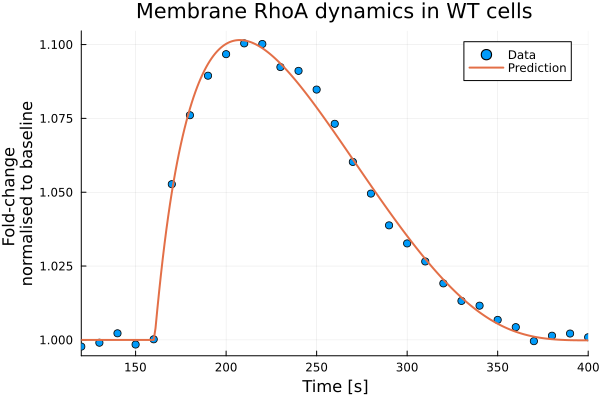

In [16]:
begin
	# Save best parameters
	saved_parameters = [0.118373, 5.0, 0.00135633, 1.22779]
	
	# Transform back ODE parameters to their symbolic expression
	saved_param = [
		Rho_model.Kon_GAP => saved_parameters[get_idxparam(Rho_model.Kon_GAP, Rho_prob)],
		Rho_model.Koff_GAP => saved_parameters[get_idxparam(Rho_model.Koff_GAP, Rho_prob)],
		Rho_model.Kon_Rho => saved_parameters[get_idxparam(Rho_model.Kon_Rho, Rho_prob)],
		Rho_model.Koff_Rho => saved_parameters[get_idxparam(Rho_model.Koff_Rho, Rho_prob)]
	]
	saved_u0 = [0;0;1]
	
    # Solve the ODE with the best parameters and plot
	saved_pred_sol = solve(remake(Rho_prob, p=saved_param, u0=saved_u0, tspan=(120, 400)), saveat=1, dtmax=0.05) 
	scatter(timeframe[12:end], median_rhoa_NONFA[12:end], label = "Data", lw=2, title = "Membrane RhoA dynamics in WT cells")
	plot!(saved_pred_sol, label = "Prediction", lw=2, idxs=3, ylabel = "Fold-change \nnormalised to baseline", xlabel = "Time [s]")
end

In [17]:
saved_param

4-element Vector{Pair{Num, Float64}}:
  Kon_GAP => 5.0
 Koff_GAP => 0.118373
  Kon_Rho => 1.22779
 Koff_Rho => 0.00135633


#### 2: membrane and DLC1-KO cells



In [19]:
# Define RhoA negative autoregulation model for membrane and DLC1-KO cells
@mtkmodel Rho_KO_dynamics begin
	
	@parameters begin
		Kon_GAP
		Koff_GAP
		Kon_Rho
		Koff_Rho
	end
	
	@variables begin
		GEF(t), [bounds = (0, 10)]
		GAP(t), [bounds = (0, 10)]
		Rho(t), [bounds = (0, 10)]
		S(t)
	end
	
	@equations begin
		
        # Define linear model
		D(GEF) ~ 0.034 * (0.2 * S - GEF)
		D(GAP) ~ Kon_GAP * (1 - GAP) * (Rho-1)^2 - Koff_GAP * GAP
		D(Rho) ~ Kon_Rho * GEF * (2 - Rho) - Koff_Rho * (GAP)^2 * Rho
		S ~ f_tanh(t)
	end
end
@mtkbuild Rho_KO_model = Rho_KO_dynamics()

Model Rho_KO_model:
Equations (3):
  3 standard: see equations(Rho_KO_model)
Unknowns (3): see unknowns(Rho_KO_model)
  GEF(t)
  GAP(t)
  Rho(t)
Parameters (4): see parameters(Rho_KO_model)
  Koff_GAP
  Kon_GAP
  Koff_Rho
  Kon_Rho
Observed (1): see observed(Rho_KO_model)

In [20]:
begin
	# Define some initial parameters for the ODE model
	KO_parameter_guess = [0.1, 0.2, 0.3, 0.4]
	
	# Build ODE problems with guess parameters and initial conditions
	Rho_KO_prob = ODEProblem(Rho_KO_model, 
		[Rho_KO_model.GEF => 0., 
			Rho_KO_model.Rho => 1.0, 
			Rho_KO_model.GAP => 0.], 
		(150.0, 400.0), KO_parameter_guess, jac = true)
end

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (150.0, 400.0)
u0: 3-element Vector{Float64}:
 0.0
 0.0
 1.0

In [58]:
# Define MSE loss function to estimate parameters
function KO_MSE_loss(new_parameters)
	
	# Substitute the initial conditions in the parameters
	new_u0 = [0;0;1]
	new_p = new_parameters[1:4]
	
	# Update the ODE problem with the new set of parameters
	KO_new_ODE_prob = remake(Rho_KO_prob, p=new_p, u0 = new_u0)
	
    # Solve the new ODE problem (saveat = numerical estimate time interval)
	KO_new_sol = solve(KO_new_ODE_prob, AutoVern9(Rodas4P()), saveat = 10, maxiters = 1e7, dtmax = 0.05, verbose = false)
	KO_new_sol_array = KO_new_sol[Rho_KO_model.Rho]
	
	# Compute the loss (sum of squares)
	if length(KO_new_sol_array) == length(median_rhoa_NONFA_KO[15:end])
		loss = sum(abs2, KO_new_sol_array .- median_rhoa_NONFA_KO[15:end])
	else
		loss = 1000
	end
	
    return loss
end

In [21]:
# Define callback function that is run at each iteration
KO_callback! = function(parameters, loss)
	
    # Add current loss value to tracking array
	push!(KO_track_loss, loss)
	
	# Tell Optimization.solve to not halt the optimization. If return true, then
    # optimization stops.
	return false
end

#8 (generic function with 1 method)

In [22]:
begin
	# Define optimization function and differentiation method
	KO_optimisation_f = Optimization.OptimizationFunction((x, p) -> KO_MSE_loss(x), Optimization.AutoForwardDiff())
	
    # Keep track of loss values during iterations
	KO_track_loss = []
	
    # Define upper and lower bound for parameters and initial conditions
	KO_lower_b = repeat([0.001], 4)
	KO_upper_b = repeat([5], 4)
	
	# Define the optimisation problem
	KO_optimisation_prob = Optimization.OptimizationProblem(KO_optimisation_f, KO_parameter_guess, ub = KO_upper_b, lb = KO_lower_b)
end

OptimizationProblem. In-place: true
u0: 4-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4

In [61]:
begin 
	# Clear the tracking array if not empty
	if !isempty(KO_track_loss)
		empty!(KO_track_loss)
	end
	
    # Run the optimisation
	KO_optim_results = Optimization.solve(KO_optimisation_prob, LBFGS(), callback = KO_callback!, maxiters = 100, progress = true)
end

In [62]:
begin
	# Retrieve initial conditions from optimisation solution
	KO_pred_u0 = [0; 0; 1]
	
    # Re-modify parameters as for optimisation
	KO_pred_p = KO_optim_results[1:4]
	
    # Solve and plot final solution
	KO_pred_sol = solve(remake(Rho_KO_prob, p=KO_pred_p, u0=KO_pred_u0, tspan=(120, 400)), saveat=1, dtmax=0.01)
	scatter(timeframe[12:end], median_rhoa_NONFA_KO[12:end], label = "Data", lw=2, title = "Membrane RhoA dynamics in DLC1-KO cells" )
	plot!(KO_pred_sol, label = "Prediction", lw=2, idxs=3, ylabel = "Fold-change \nnormalised to baseline", xlabel = "Time [s]")
end

In [63]:
# Visualise optimisation statistics
KO_optim_results.original

In [64]:
begin
	# Plot the dynamics of all proteins
	plot(KO_pred_sol, title = "aGEF, aGAP and aRhoA simultaneous dynamics", xlabel = "Time [s]")
end

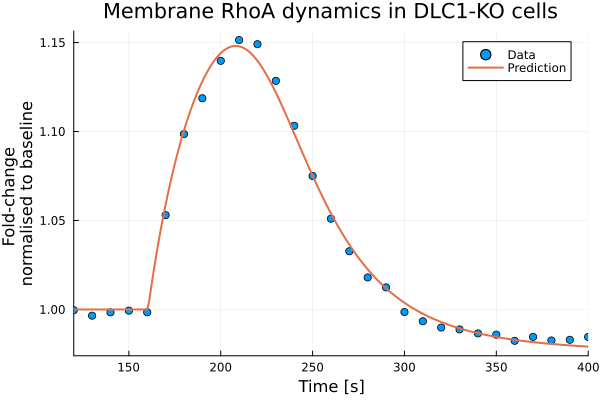

In [23]:
begin
	# Save best parameters
	saved_KO_parameters = [0.0138277, 0.0315648, 5.0, 1.36068]
	
    # Transform back ODE parameters to their symbolic expression
	saved_KO_param = [
		Rho_KO_model.Kon_GAP => saved_KO_parameters[get_idxparam(Rho_KO_model.Kon_GAP, Rho_KO_prob)],
		Rho_KO_model.Koff_GAP => saved_KO_parameters[get_idxparam(Rho_KO_model.Koff_GAP, Rho_KO_prob)],
		Rho_KO_model.Kon_Rho => saved_KO_parameters[get_idxparam(Rho_KO_model.Kon_Rho, Rho_KO_prob)], 
		Rho_KO_model.Koff_Rho => saved_KO_parameters[get_idxparam(Rho_KO_model.Koff_Rho, Rho_KO_prob)]]
	saved_KO_u0 = [0;0;1] 
	
    # Solve the ODE with the best parameters and plot
	saved_KO_pred_sol = solve(remake(Rho_KO_prob, p=saved_KO_param, u0=saved_KO_u0, tspan=(120, 400)), saveat=1, dtmax=0.05) 
	scatter(timeframe[12:end], median_rhoa_NONFA_KO[12:end], label = "Data", lw=2, title = "Membrane RhoA dynamics in DLC1-KO cells")
	plot!(saved_KO_pred_sol, label = "Prediction", lw=2, idxs=3, ylabel = "Fold-change \nnormalised to baseline", xlabel = "Time [s]")
end

In [24]:
saved_KO_param

4-element Vector{Pair{Num, Float64}}:
  Kon_GAP => 0.0315648
 Koff_GAP => 0.0138277
  Kon_Rho => 1.36068
 Koff_Rho => 5.0


### Comparison between DLC1-KO and WT data fitting



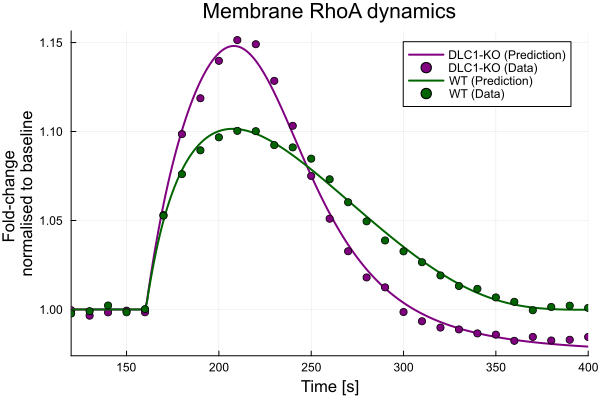

In [25]:
begin
	# Plot results for each condition (WT and DLC1-KO)
	plot(saved_KO_pred_sol, lw=2, idxs=3, linecolor="#800080", label = "DLC1-KO (Prediction)", fontfamily="Arial")
	scatter!(timeframe[12:end], median_rhoa_NONFA_KO[12:40], label = "DLC1-KO (Data)", lw=2, title = "Membrane RhoA dynamics", markercolor="#800080")
	plot!(saved_pred_sol, lw=2, idxs=3, linecolor="#006400",label = "WT (Prediction)")
	scatter!(timeframe[12:end], median_rhoa_NONFA[12:end], label = "WT (Data)", markercolor="#006400")
	xlabel!("Time [s]")
	ylabel!("Fold-change \nnormalised to baseline")
	#savefig("../Data/membrane_plot_linear.svg")
end

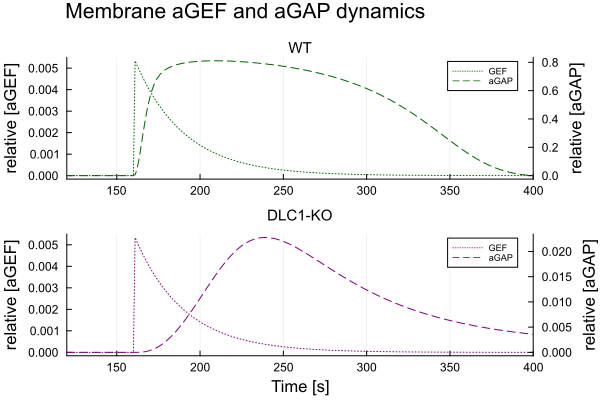

In [26]:
begin
	gef_plot = plot(saved_pred_sol, title = "", xlabel = "", idxs=1, linecolor="#006400", linestyle=:dot, legend_font_pointsize=6, ylabel="relative [aGEF]", legend=:best, fontfamily="Arial")
	plot!(timeframe[12:end], NaN.*timeframe[12:end], label = "aGAP", linestyle=:dash, linecolor="#006400")
	plot!(twinx(), saved_pred_sol, title = "\nWT", legend=false, xlabel = "", idxs=2, linecolor="#006400", linestyle=:dash, titlefontsize=10, ylabel="relative [aGAP]")
	gef_plot_KO = plot(saved_KO_pred_sol, title = "DLC1-KO", xlabel = "Time [s]", idxs=1, linecolor="#800080", linestyle=:dot, titlefontsize=10, legend_font_pointsize=6, ylabel="relative [aGEF]", fontfamily="Arial")
	plot!(timeframe[12:end], NaN.*timeframe[12:end], label = "aGAP", linestyle=:dash, linecolor="#800080")
	plot!(twinx(), saved_KO_pred_sol, title = "", idxs=2, linecolor="#800080", linestyle=:dash, xlabel = "", legend=false, ylabel="relative [aGAP]")
	plot(gef_plot, gef_plot_KO, layout=(2, 1), plot_title="Membrane aGEF and aGAP dynamics", plot_titlelocation=:left, plot_titlefontsize=14, )
	#savefig("../Data/membrane_all_plot_linear.svg")
end